### [Predictive Maintenance with Time Series](https://medium.com/@kylejones_47003/predictive-maintenance-with-time-series-in-python-using-pca-statistics-and-lstms-430aa8e79fc5)

Predictive maintenance uses data to anticipate failure before it happens. The goal is simple: intervene early enough to reduce downtime and avoid unnecessary maintenance.

##### CMAPSS Jet Engine Simulated Data

The data comes from the *NASA turbofan engine degradation simulation* dataset, which simulates multiple engines running until failure. Each engine is represented by a unit ID, and each row is a cycle (i.e., a timestamp). Sensors record pressure, temperature, and vibration, among other measurements.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas statsmodels scikit-learn matplotlib
!pip install -q "tensorflow==2.18"

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Layer, LSTM, Dense

In [4]:
# Custom minimalist plot style
plt.rcParams.update({
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.linewidth': 0.8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

In [5]:
train01_ds = 'https://raw.githubusercontent.com/edwardzjl/CMAPSSData/refs/heads/master/train_FD001.txt'
df = pd.read_csv(train01_ds, sep="\s+", header=None)
df.dropna(axis=1, inplace=True)
df.columns = ['unit', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

rule01_ds = 'https://raw.githubusercontent.com/edwardzjl/CMAPSSData/refs/heads/master/RUL_FD001.txt'
rul = pd.read_csv(rule01_ds, header=None)
rul.columns = ['max_RUL']
rul['unit'] = rul.index + 1
last_cycle = df.groupby('unit')['time'].max().reset_index()
last_cycle.columns = ['unit', 'max_time']
df = df.merge(last_cycle, on='unit')
df['RUL'] = df['max_time'] - df['time']
df['distress'] = df['RUL'] < 20

selected_sensors = ['sensor_9', 'sensor_14', 'sensor_4', 'sensor_3', 'sensor_17', 'sensor_2']

In [6]:
# -----------------------------
# PCA 
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[selected_sensors])

pca = PCA(n_components=3)
pca_factors = pca.fit_transform(X_scaled)

df[['pca_1', 'pca_2', 'pca_3']] = pca_factors

##### PCA for Healthy Bounds

Define what “healthy” looks like using a lower-dimensional space. Then detect when a machine drifts too far from it.

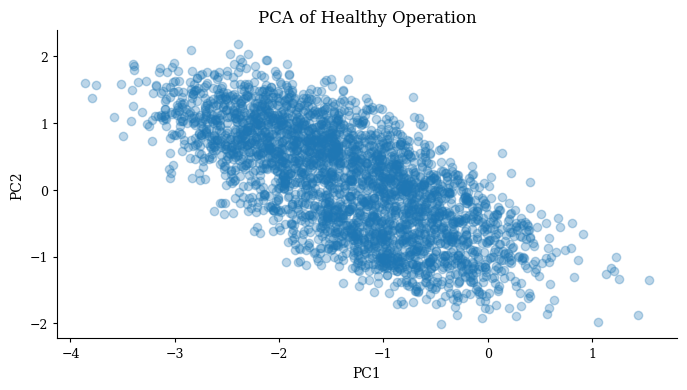

In [7]:
# -----------------------------
# PCA for Healthy Boundaries (Visualization)
# -----------------------------
healthy_df = df[df['time'] <= 30]
X_pca = healthy_df[['pca_1', 'pca_2']].values
center = X_pca.mean(axis=0)

df['pca_distance'] = np.linalg.norm(df[['pca_1', 'pca_2']].values - center, axis=1)
threshold = df['pca_distance'].mean() + 3 * df['pca_distance'].std()
df['pca_anomaly'] = df['pca_distance'] > threshold

plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.title('PCA of Healthy Operation')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
# plt.savefig("pca_healthy_bounds.png")
plt.show()

##### Forecasting Sensor Drift with Time Series Models

Use statistical time series models to forecast a sensor. If the prediction diverges from the actual value, the engine may be drifting into failure.

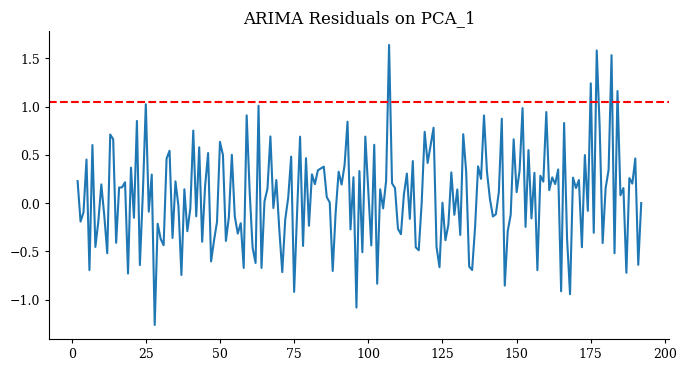

In [8]:
# -----------------------------
# Time Series Modeling (ARIMA with PCA)
# -----------------------------
unit_df = df[df['unit'] == 1]
model = sm.tsa.ARIMA(unit_df['pca_1'], order=(1, 1, 1))
fit = model.fit()
forecast = fit.predict(start=1, end=len(unit_df), dynamic=False)
residuals = unit_df['pca_1'].iloc[1:].values - forecast[1:]

plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.axhline(y=2 * residuals.std(), color='r', linestyle='--')
plt.title('ARIMA Residuals on PCA_1')
# plt.savefig("arima_residuals_pca1.png")
plt.show()

##### Anomaly Detection with Isolation Forest

Automatically flag abnormal behavior based on the multivariate distribution of sensor readings.

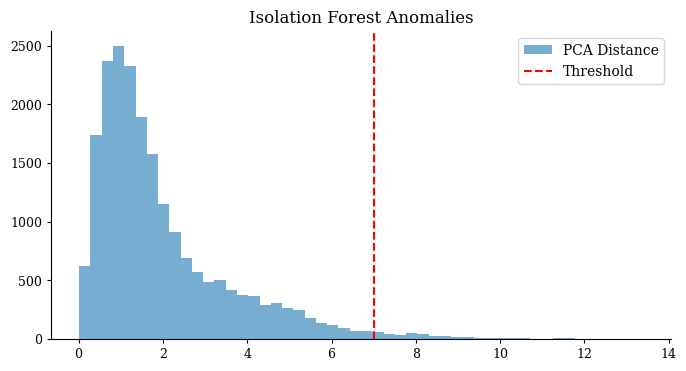

In [9]:
# -----------------------------
# Anomaly Detection (Isolation Forest on PCA)
# -----------------------------
pca_features = df[['pca_1', 'pca_2', 'pca_3']].values
clf = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_iforest'] = clf.fit_predict(pca_features) == -1

plt.figure(figsize=(8, 4))
plt.hist(df['pca_distance'], bins=50, alpha=0.6, label='PCA Distance')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Isolation Forest Anomalies')
plt.legend()
# plt.savefig("iforest_anomaly_pca.png")
plt.show()

##### Sequence Modeling to Flag Engines in Distress

Detect not just isolated outliers, but sequences that signal an engine is approaching failure.

In [10]:
def make_sequences(df, sensor, window=30):
    sequences, labels = [], []
    for _, group in df.groupby('unit'):
        values = group[sensor].values
        targets = group['distress'].values
        for i in range(len(values) - window):
            sequences.append(values[i:i+window])
            labels.append(targets[i+window])
    return np.array(sequences), np.array(labels)

X_seq, y_seq = make_sequences(df, 'sensor_9')
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_rf, y_train_rf)

RandomForestClassifier()

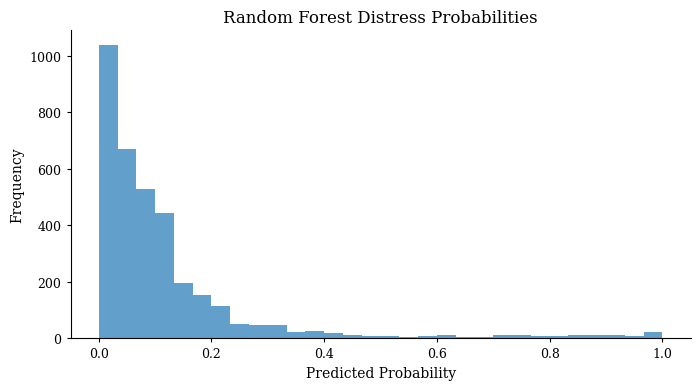

In [11]:
# Visualization of prediction probabilities
y_pred_rf = rf_clf.predict_proba(X_test_rf)[:, 1]
plt.figure(figsize=(8, 4))
plt.hist(y_pred_rf, bins=30, alpha=0.7)
plt.title('Random Forest Distress Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
# plt.savefig("rf_sequence_classification.png")
plt.show()

##### Long Short-Term Memory (LSTM)

Learn the hidden patterns in a sequence of sensor readings that suggest an engine is about to fail.

Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9031 - loss: 0.2169 - val_accuracy: 0.9752 - val_loss: 0.0633
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9703 - loss: 0.0706 - val_accuracy: 0.9724 - val_loss: 0.0570
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9747 - loss: 0.0610 - val_accuracy: 0.9766 - val_loss: 0.0581
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9745 - loss: 0.0615 - val_accuracy: 0.9766 - val_loss: 0.0551
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9755 - loss: 0.0601 - val_accuracy: 0.9752 - val_loss: 0.0567
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9755 - loss: 0.0569 - val_accuracy: 0.9809 - val_loss: 0.0457
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9750 - loss: 0.0567 - val_accuracy: 0.9823 - val_loss: 0.0435
Epoch 8/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9768 - loss: 0.0539 - val_ac

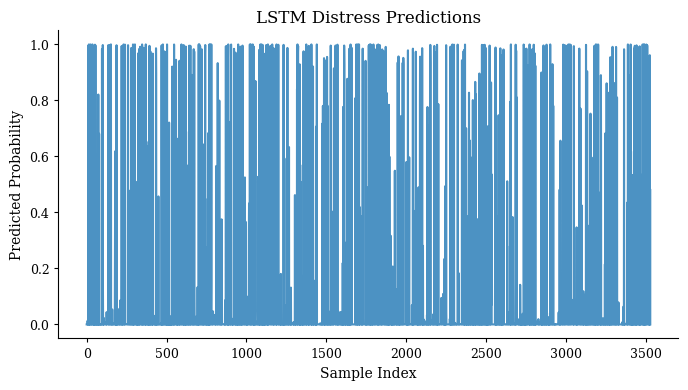

In [12]:
# -----------------------------
# PCA-based LSTM
# -----------------------------
def make_pca_lstm_sequences(df, pca_cols, window=30):
    sequences, labels = [], []
    for _, group in df.groupby('unit'):
        values = group[pca_cols].values
        targets = group['distress'].values
        for i in range(len(values) - window):
            sequences.append(values[i:i+window])
            labels.append(targets[i+window])
    return np.array(sequences), np.array(labels)

pca_cols = ['pca_1', 'pca_2', 'pca_3']
X, y = make_pca_lstm_sequences(df, pca_cols)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

pred_lstm = model_lstm.predict(X_test).flatten()
plt.figure(figsize=(8, 4))
plt.plot(pred_lstm, alpha=0.8)
plt.title('LSTM Distress Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
# plt.savefig("lstm_predictions.png")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


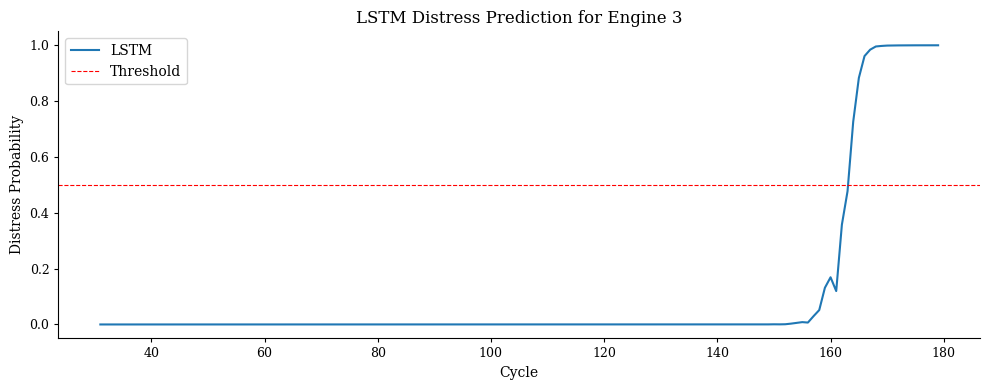

In [13]:
# Predict and compare for a specific engine
unit_id = 3
window = 30
engine_data = df[df['unit'] == unit_id].copy()
X_engine = np.array([engine_data[['pca_1', 'pca_2', 'pca_3']].values[i:i+window] for i in range(len(engine_data) - window)])
cycles = engine_data['time'].values[window:]

# LSTM prediction
pred_lstm_engine = model_lstm.predict(X_engine).flatten()

# Plot LSTM only
plt.figure(figsize=(10, 4))
plt.plot(cycles, pred_lstm_engine, label='LSTM')
plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8, label='Threshold')
plt.title(f'LSTM Distress Prediction for Engine {unit_id}')
plt.xlabel('Cycle')
plt.ylabel('Distress Probability')
plt.legend()
plt.tight_layout()
# plt.savefig("lstm_engine_prediction.png")
plt.show()

##### Attention-Based Models

Give the model the ability to focus on the most important parts of the sequence when making predictions.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.2351 - val_loss: 0.0920
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0954 - val_loss: 0.0783
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0750 - val_loss: 0.0726
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0762 - val_loss: 0.0567
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0656 - val_loss: 0.0692
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0623 - val_loss: 0.0571
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0618 - val_loss: 0.0537
Epoch 8/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0567 - val_loss: 0.0479
Epoch 9/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0517 - val_loss: 0.0517
Epoch 10/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0560 - val_loss: 0.0550


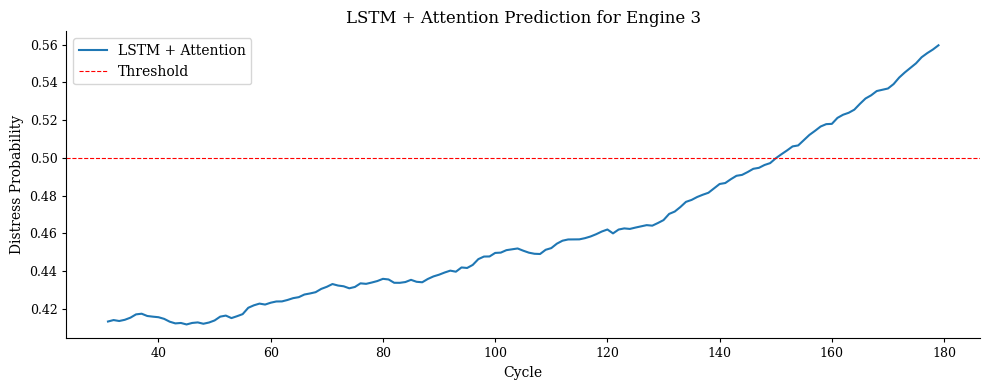

In [14]:
# -----------------------------
# LSTM + Attention
# -----------------------------
class AttentionWithWeights(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal')
    def call(self, inputs):
        scores = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(scores, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context, weights

input_seq = Input(shape=(X.shape[1], X.shape[2]))
x = LSTM(64, return_sequences=True)(input_seq)
context, attn_weights = AttentionWithWeights()(x)
output = Dense(1, activation='sigmoid', name='pred')(context)
model_attn = Model(inputs=input_seq, outputs={'pred': output, 'attn': attn_weights})
model_attn.compile(
    optimizer='adam',
    loss={'pred': 'binary_crossentropy'},
    metrics={'pred': 'accuracy'}
)

# LSTM + Attention prediction
pred_dict = model_attn.predict(X_engine)
pred_attn_engine = pred_dict['pred'].flatten()

model_attn.fit(X_train, {'pred': y_train}, epochs=10, batch_size=32, validation_split=0.1)

# Plot LSTM + Attention only
plt.figure(figsize=(10, 4))
plt.plot(cycles, pred_attn_engine, label='LSTM + Attention')
plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8, label='Threshold')
plt.title(f'LSTM + Attention Prediction for Engine {unit_id}')
plt.xlabel('Cycle')
plt.ylabel('Distress Probability')
plt.legend()
plt.tight_layout()
# plt.savefig("lstm_attention_engine_prediction.png")
plt.show()

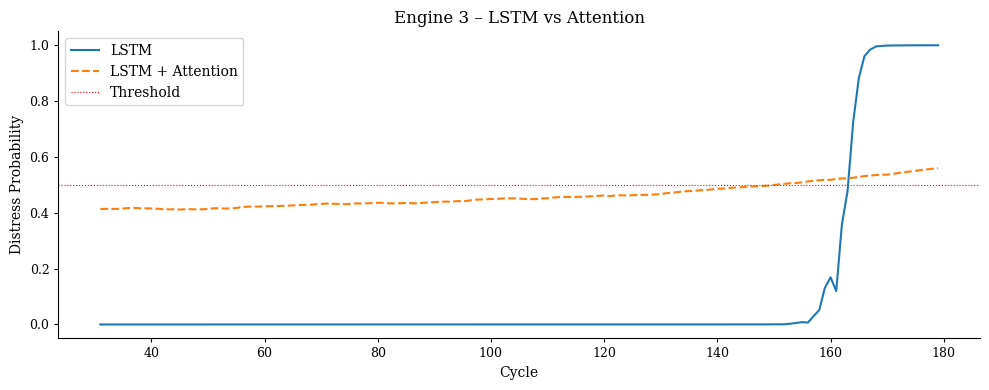

In [15]:
# Combined comparison
plt.figure(figsize=(10, 4))
plt.plot(cycles, pred_lstm_engine, label='LSTM')
plt.plot(cycles, pred_attn_engine, label='LSTM + Attention', linestyle='--')
plt.axhline(0.5, color='red', linestyle=':', linewidth=0.8, label='Threshold')
plt.title(f'Engine {unit_id} – LSTM vs Attention')
plt.xlabel('Cycle')
plt.ylabel('Distress Probability')
plt.legend()
plt.tight_layout()
# plt.savefig("comparison_lstm_vs_attention.png")
plt.show()